<a href="https://colab.research.google.com/github/YichenCai/ams_ai_shortcourse_2024/blob/main/modules/learningmethods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AMS 2024 AI Short Course: Learning Methods in AI**

---

*Notebook by Maria J. Molina (University of Maryland, College Park)*

This Colab Notebook demonstrates different types of learning methods in artificial intelligence, with a specific focus on supervised and unsupervised learning, along with regression and classification problems.

## **Supervised Learning**

---

Supervised learning refers to machine learning tasks where the dataset used contains both the predictors (x) and predictands (y) *a priori.* In other words, these are situations where we know the "answer(s)" beforehand. This information is useful for supervised tasks because the machine learning model can receive information about the skill of its own predictions based on the known predictands, and then these signals are used to update model weights accordingly to improve subsequent predictions. The predictand(s) can be continuous or discrete, which would lend itself to a regression or classification type of problem respectively.

We often refer to the predictands as "labels," particularly in the case of classification problems.



![supervised](https://drive.google.com/uc?export=view&id=1g74XtOQO7jZsEUxHEDnD4aKYAOOnhQjE)

Labels can be of different data types, such as:

*   Single point value
*   Single image pixel (i.e., grid-cell)
*   Image-based (i.e., spatial in nature)
*   Temporal (i.e., time series)

In supervised learning, we can have regression or classification problems, which are further detailed below.

## Regression

---

**In regression problems**, we aim to predict the specific value of *something*. These values are generally continuous in nature. A simple example from statistics would be a linear regression y = mx + b, where y (our predictand) would be a continuous value that we can predict using our input x (our predictor).

![supervised](https://drive.google.com/uc?export=view&id=1itJDHx1gq4WqEQ00hxKafMQ9-A9BjEhB)


Some examples of regression problems in the environmental sciences could include:

*   tropical cyclone maximum wind speed at a certain lead time
*   maximum land surface temperature in an urban area
*   percentage of cloud coverage over a predifined domain
*   bias correction of subseasonal forecasts of precipitation

Importantly, when using various input variables (i.e., features or channels), normalizing or standardizing the variables is needed to make sure they have a similar dynamic range. Otherwise, some input variables may have much larger magnitudes than other input variables, limiting their contributions to the learning process. By normalizing/standardizing our features, we facilitate meaningful comparisons between features. This practice can also improve machine learning model convergence.

Standardization involves centering the respective data to have a mean of zero and a standard deviation of one, which can be achieved by subtracting the mean and dividing by the standard deviation (i.e., z-score). Normalization involves the scaling of data to a set range, such as from 0 to +1 or -1 to +1, by using the minimum and maximum values of the respective variable.

Here we have some helper functions for normalizing and standardizing our data using numpy.

In [68]:
import numpy as np

def z_score(da):
    """
    Compute z-score for training data.
    Normalizing data for ML model training.
    Args:
        da (array): Array of training variable.
    """
    return (da - np.mean(da)) / np.std(da)

def min_max_scale(da):
    """
    Scale training data by minimum and maximum values.
    Args:
        da (array): Array of training variable.
    """
    return (da - np.min(da)) / (np.max(da) - np.min(da))

We can create a little random array just to visualize what the normalization and standardization methods do to our data.

In [70]:
np.random.seed(0)
sample_array = np.random.rand(10)
print(sample_array)

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548  0.64589411
 0.43758721 0.891773   0.96366276 0.38344152]


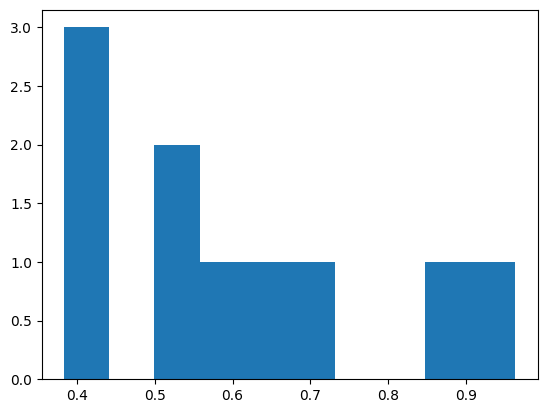

In [3]:
import matplotlib.pyplot as plt

plt.hist(sample_array)
plt.show()

In [69]:
plt.hist(z_score(sample_array))
plt.title('z-score')
plt.show()

plt.hist(min_max_scale(sample_array))
plt.title('min-max')
plt.show()

NameError: name 'sample_array' is not defined

As we can see on the x-axis in the above images, z-score results in our data having a mean of zero while min-max results in our data spanning values from 0 to +1, with both methods not changing the actual distribution of our data.

## **Supervised Learning Regression Example**

Now, we will proceed with training a neural network in a supervised learning regression application.

We will use a dataset from Molina et al. (2021) consisting of thunderstorms generated using a 4-km horizontal resolution WRF simulation. We are using a small portion of the dataset, specifically thunderstorms simulated for April 27, 2011 over the continental United States.

In [3]:
!wget https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc

--2025-08-05 15:31:41--  https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109400556 (104M) [application/octet-stream]
Saving to: ‘current_SP3hourly_20110427.nc’

current_SP3hourly_2 100%[===================>] 104.33M  25.1MB/s    in 4.9s    

2025-08-05 15:31:47 (21.4 MB/s) - ‘current_SP3hourly_20110427.nc’ saved [109400556/109400556]



Let's visualize the dataset. We can use python libraries for this.

In [71]:
import matplotlib.pyplot as plt
import xarray as xr

In [72]:
ds = xr.open_dataset('current_SP3hourly_20110427.nc')

The dataset contains 2,224 storm samples that were generated using the github reposity [deep-conus](https://github.com/mariajmolina/deep-conus). Each sample is 32x32 grid cells (i.e., pixels) with each grid cell spanning 4-km.

Let's visualize some of the variables.

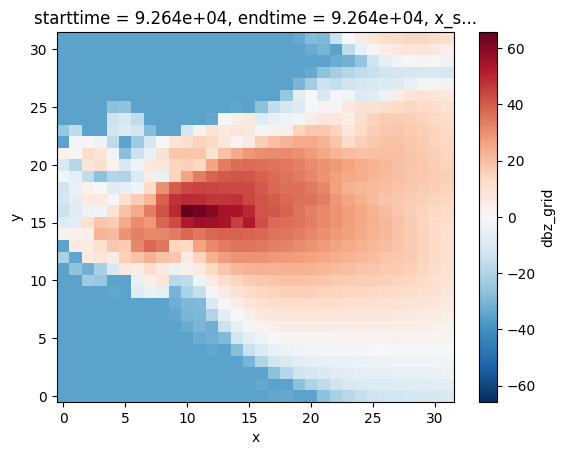

In [ ]:
# simulated radar reflectivity
ds['dbz_grid'].isel(starttime=0).plot()

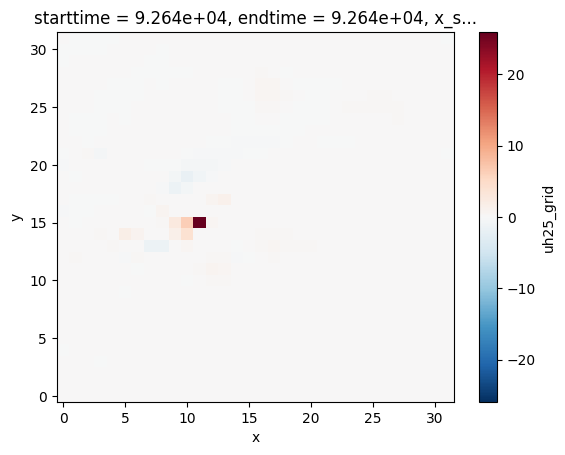

In [ ]:
# gridded updraft helicity from 2-5 km
ds['uh25_grid'].isel(starttime=0).plot()

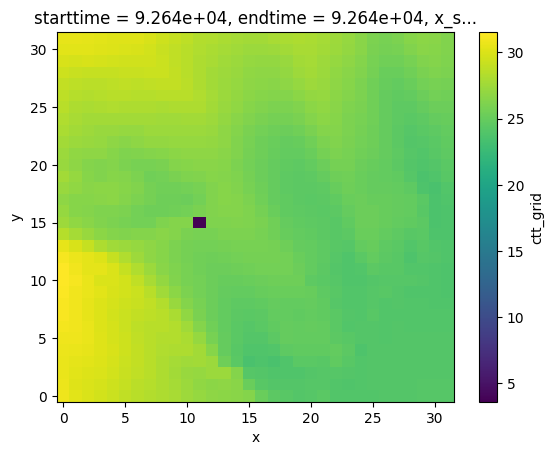

In [ ]:
# gridded cloud top temperature
ds['ctt_grid'].isel(starttime=0).plot()

Now we will preprocess our training and testing data. We need to split our data into a training and testing sets, and standardize.

In [73]:
def random_split(data, label, split=0.3, seed=0):
    """
    Help spliting data randomly for training and testing.
    """
    np.random.seed(0)
    da_indx = np.random.permutation(data.shape[0])
    data  = data[da_indx.astype(int)]
    label = label[da_indx.astype(int)]
    init_range = int(data.shape[0] * (1 - split))
    print(int(data.shape[0] * (1 - split)), data.shape[0] * (1 - split))
    return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [74]:
features = xr.concat([
    ds['dbz_grid'].expand_dims(dim='feature', axis=3),
    ds['ctt_grid'].expand_dims(dim='feature', axis=3)],
          dim='feature')

In [41]:
print(train_label.shape)

(1556, 1)


In [75]:
# grab the maximum of the dbz to use as our labels (regression)
labels = ds['dbz_grid'].expand_dims(dim='feature', axis=3).max('x').max('y')

In [14]:
print(labels)

<xarray.DataArray 'dbz_grid' (starttime: 2224, feature: 1)> Size: 9kB
array([[65.721054],
       [58.54062 ],
       [58.54062 ],
       ...,
       [45.41483 ],
       [37.786957],
       [42.48563 ]], dtype=float32)
Coordinates:
  * starttime  (starttime) float64 18kB 9.264e+04 9.264e+04 ... 9.266e+04
    endtime    (starttime) float64 18kB ...
    x_speed    (starttime) int64 18kB ...
    y_speed    (starttime) int64 18kB ...
Dimensions without coordinates: feature


In [76]:
train_feats, train_label, test_feats, test_label = random_split(features, labels)

1556 1556.8


In [77]:
print(train_feats.shape[0], train_label.shape[0]*3, test_feats.shape[0], test_label.shape[0]*7)

1556 4668 668 4676


In [78]:
# normalization of our training data (note each feature individually processed!)
train_feats_standardized = xr.concat([
    z_score(train_feats.isel(feature=0).expand_dims(dim='feature', axis=3)),
    z_score(train_feats.isel(feature=1).expand_dims(dim='feature', axis=3))],
                                     dim='feature')

train_label_standardized = z_score(train_label)

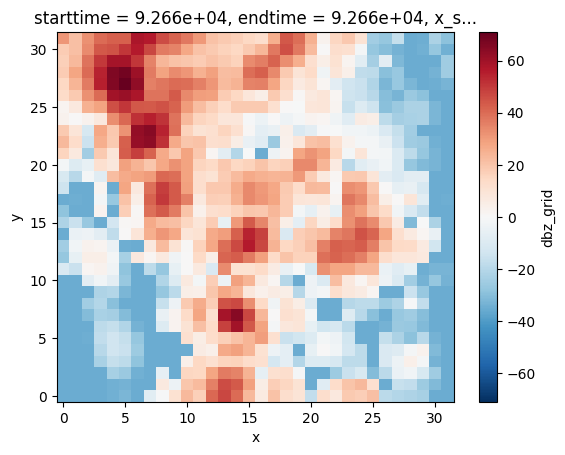

In [ ]:
train_feats.isel(feature=0,starttime=15).plot()

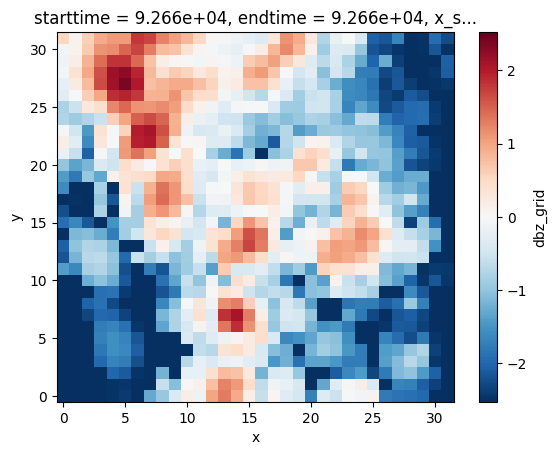

In [ ]:
train_feats_standardized.isel(feature=0,starttime=15).plot()

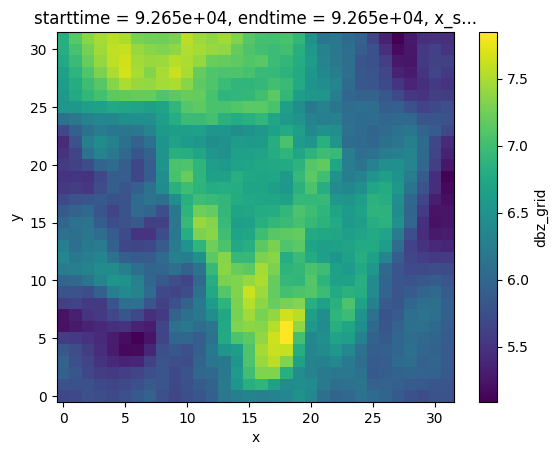

In [ ]:
train_feats.isel(feature=1,starttime=100).plot()

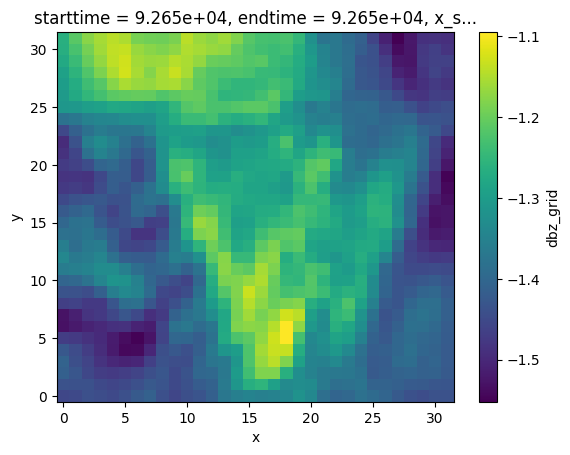

In [ ]:
train_feats_standardized.isel(feature=1,starttime=100).plot()

Let's proceed to build a simple convolutional neural network that will take images as the input and predict the respective storm's maximum updraft helicity.

In [79]:
import keras
from keras import layers

In [80]:
# lets use two input variables (dbz_grid and ctt_grid)
number_of_features = 2

In [81]:
model = keras.Sequential()

# input
model.add(keras.Input(shape=(32, 32, number_of_features)))  # 32x32 images

# data augmentation layers
#model.add(layers.RandomFlip("horizontal_and_vertical"))
#model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

# hidden layers
model.add(layers.Conv2D(32, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

# Now that we have 4x4 feature maps, now apply global max pooling.
model.add(layers.GlobalMaxPooling2D())

# Finally, we add last fully connected (dense) layers
model.add(layers.Dense(64))
model.add(layers.Dense(1, activation="linear"))

# print model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_4          │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,281 (395.63 KB)

 Trainable params: 101,281 (395.63 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
608+18496+73856+8256+65

101281

Proceeding with compiling our model and selecting some metrics to use.

Some common evaluation metrics used with regression problems are:

Mean absolute error (MAE): $\frac{1}{N} \sum\limits_{i = 1}^{N} \lvert \hat{y}_i - y_i \rvert$

Mean squared error (MSE): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2$


More evalution metrics can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [82]:
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
]

In [83]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

In [84]:
BATCH_SIZE = 32
EPOCHS = 10

In [32]:
model.fit?

In [18]:
history = model.fit(
    x=train_feats_standardized.values,
    y=train_label_standardized.values,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.8364 - mean_squared_error: 0.8364 - root_mean_squared_error: 0.9090 - val_loss: 0.5336 - val_mean_squared_error: 0.5336 - val_root_mean_squared_error: 0.7305
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0.4239 - mean_squared_error: 0.4239 - root_mean_squared_error: 0.6502 - val_loss: 0.3360 - val_mean_squared_error: 0.3360 - val_root_mean_squared_error: 0.5796
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.2884 - mean_squared_error: 0.2884 - root_mean_squared_error: 0.5369 - val_loss: 0.2904 - val_mean_squared_error: 0.2904 - val_root_mean_squared_error: 0.5389
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.2388 - mean_squared_error: 0.2388 - root_mean_squared_error: 0.4886 - val_loss: 0.2551 - val_mean_squared_error: 0.2551 - val_root_mean_squared_error: 0.5050
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.1615 - mean_squared_error: 0.1615 - root_mean_squared_error: 0

In [31]:
history.history

{'loss': [0.5863139629364014,
  0.37005165219306946,
  0.28509679436683655,
  0.18532662093639374,
  0.20407195389270782,
  0.15601487457752228,
  0.12510275840759277,
  0.11365097016096115,
  0.09917714446783066,
  0.10160373151302338],
 'mean_squared_error': [0.5863139629364014,
  0.37005165219306946,
  0.28509679436683655,
  0.18532662093639374,
  0.20407195389270782,
  0.15601487457752228,
  0.12510275840759277,
  0.11365097016096115,
  0.09917714446783066,
  0.10160373151302338],
 'root_mean_squared_error': [0.7657114267349243,
  0.6083186864852905,
  0.5339445471763611,
  0.4304957985877991,
  0.4517432451248169,
  0.39498719573020935,
  0.3536986708641052,
  0.3371216058731079,
  0.314924031496048,
  0.3187533915042877],
 'val_loss': [0.41945746541023254,
  0.3478146195411682,
  0.26700714230537415,
  0.24402527511119843,
  0.221767395734787,
  0.3333452045917511,
  0.3356458246707916,
  0.1984506994485855,
  0.1758590191602707,
  0.16589203476905823],
 'val_mean_squared_error':

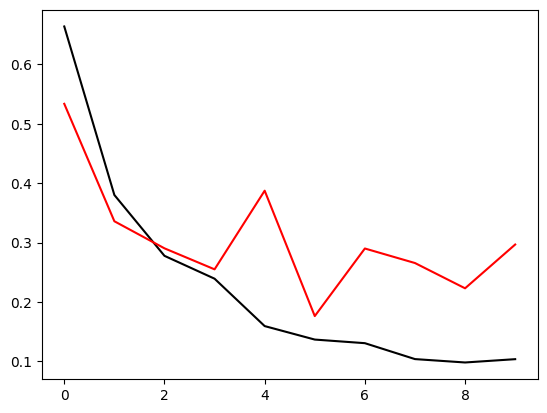

In [19]:
plt.plot(history.history["mean_squared_error"], c='k')
plt.plot(history.history["val_mean_squared_error"], c='r')
plt.show()

Lets now evaluate the model using the test dataset. We need to standardize the data, but using the mean and standard deviation of the training set.

In [20]:
def z_score_testing(da, testdata):
    """
    Compute z-score for testing data.
    Args:
        da (array): Array of training variable.
    """
    return (testdata - np.mean(da)) / np.std(da)

In [21]:
# normalization of our training data (note each feature individually processed!)
test_feats_standardized = xr.concat([
    z_score_testing(
        train_feats.isel(feature=0).expand_dims(dim='feature', axis=3),
        test_feats.isel(feature=0).expand_dims(dim='feature', axis=3)
        ),
    z_score_testing(
        train_feats.isel(feature=1).expand_dims(dim='feature', axis=3),
        test_feats.isel(feature=1).expand_dims(dim='feature', axis=3)
        )],
                                     dim='feature')

test_label_standardized = z_score_testing(train_label, test_label)

In [22]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_feats_standardized.values, test_label_standardized.values, batch_size=128)
print(results)

Evaluate on test data
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.3074 - mean_squared_error: 0.3074 - root_mean_squared_error: 0.5544
[0.30160799622535706, 0.30160799622535706, 0.549188494682312]


In [23]:
# generate predictions using the trained model
predictions = model.predict(test_feats_standardized.values)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [ ]:
print(test_feats_standardized.values.shape, predictions.shape)
print(train_feats_standardized.values.shape, train_label_standardized.values.shape)

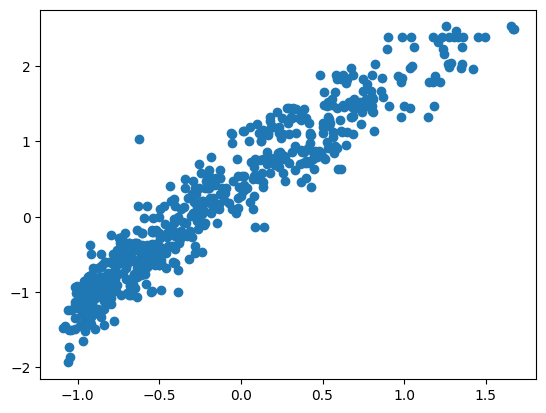

In [24]:
# visualize predictions vs ground truth
plt.scatter(predictions, test_label_standardized.values)
plt.show()

# Tutorial Practice: How does batch size impact model training?

---

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import keras
from keras import layers

def z_score(da):
    """
    Compute z-score for training data.
    Normalizing data for ML model training.
    Args:
        da (array): Array of training variable.
    """
    return (da - np.mean(da)) / np.std(da)

def min_max_scale(da):
    """
    Scale training data by minimum and maximum values.
    Args:
        da (array): Array of training variable.
    """
    return (da - np.min(da)) / (np.max(da) - np.min(da))

def random_split(data, label, split=0.3, seed=0):
    """
    Help spliting data randomly for training and testing.
    """
    np.random.seed(0)
    da_indx = np.random.permutation(data.shape[0])
    data  = data[da_indx.astype(int)]
    label = label[da_indx.astype(int)]
    init_range = int(data.shape[0] * (1 - split))
    print(int(data.shape[0] * (1 - split)), data.shape[0] * (1 - split))
    return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

# !wget https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc
ds = xr.open_dataset('current_SP3hourly_20110427.nc')

features = xr.concat([
    ds['dbz_grid'].expand_dims(dim='feature', axis=3),
    ds['ctt_grid'].expand_dims(dim='feature', axis=3)],
          dim='feature')
# grab the maximum of the dbz to use as our labels (regression)
labels = ds['dbz_grid'].expand_dims(dim='feature', axis=3).max('x').max('y')

# split the data
train_feats, train_label, test_feats, test_label = random_split(features, labels)

# normalization of our training data (note each feature individually processed!)
train_feats_standardized = xr.concat([
    z_score(train_feats.isel(feature=0).expand_dims(dim='feature', axis=3)),
    z_score(train_feats.isel(feature=1).expand_dims(dim='feature', axis=3))],
                                     dim='feature')

train_label_standardized = z_score(train_label)

1556 1556.8


In [ ]:
BATCH_SIZEs = [16,32,64,128]
EPOCHS = 80
LRs = [1e-2, 1e-3, 1e-4, 1e-5, 5e-6]
number_of_features = 2

history = {}

# fig,axs = plt.subplots(1,2,figsize=[13,5])
for BATCH_SIZE in BATCH_SIZEs:
    history[f'BS_{BATCH_SIZE}'] = {}
    for LR in LRs:
        print(f'***********************************')
        print(f'BS_{BATCH_SIZE}_LR_{LR:.0e}')

        # recreate the model object
        model = keras.Sequential()

        # input
        model.add(keras.Input(shape=(32, 32, number_of_features)))  # 32x32 images

        # data augmentation layers
        #model.add(layers.RandomFlip("horizontal_and_vertical"))
        #model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # hidden layers
        model.add(layers.Conv2D(32, 3, strides=1, padding="same", activation="relu"))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(64, 3, strides=1, padding="same", activation="relu"))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(128, 3, strides=1, padding="same", activation="relu"))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        # Now that we have 4x4 feature maps, now apply global max pooling.
        model.add(layers.GlobalMaxPooling2D())

        # Finally, we add last fully connected (dense) layers
        model.add(layers.Dense(64))
        model.add(layers.Dense(1, activation="linear"))

        # model.summary()

        METRICS = [
            keras.metrics.MeanSquaredError(name='mean_squared_error'),
            keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
        ]

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=LR),
            loss="mean_squared_error",
            metrics=METRICS
        )

        hst = model.fit(
            x=train_feats_standardized.values,
            y=train_label_standardized.values,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_split=0.1,
            shuffle=True,
        )
        history[f'BS_{BATCH_SIZE}'][f'LR_{LR:.0e}'] = hst

import pickle
with open('my_dict.pkl', 'wb') as f:
    pickle.dump(history, f)

***********************************
BS_16_LR_1e-02
Epoch 1/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 19.6752 - mean_squared_error: 19.6752 - root_mean_squared_error: 3.8931 - val_loss: 0.4819 - val_mean_squared_error: 0.4819 - val_root_mean_squared_error: 0.6942
Epoch 2/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.4341 - mean_squared_error: 0.4341 - root_mean_squared_error: 0.6579 - val_loss: 0.6793 - val_mean_squared_error: 0.6793 - val_root_mean_squared_error: 0.8242
Epoch 3/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.3146 - mean_squared_error: 0.3146 - root_mean_squared_error: 0.5605 - val_loss: 0.3198 - val_mean_squared_error: 0.3198 - val_root_mean_squared_error: 0.5655
Epoch 4/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.2009 - mean_squared_error: 0.2009 - root_mean_squared_error: 0.4475 - val_loss: 0.4738 - val_mean_squared_error: 0.4738 - val_root_mean_squared_error: 0.6883
Epoch 5/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.2196 - mea

In [51]:
LRs, BATCH_SIZEs

([0.01, 0.001, 0.0001, 1e-05, 5e-06], [16, 32, 64, 128])

In [ ]:
fig,axs = plt.subplots(1,2,figsize=[20,8])
for BATCH_SIZE in BATCH_SIZEs:
    history[f'BS_{BATCH_SIZE}'] = {}
    for LR in LRs:
      hst = history[f'BS_{BATCH_SIZE}'][f'LR_{LR:.0e}'].history
      mse = hst['mean_squared_error']
      val_mse = hst['val_mean_squared_error']

      axs[0].plot(mse,label=f'BS_{BATCH_SIZE}_LR_{LR:.0e}')
      axs[1].plot(val_mse,label=f'BS_{BATCH_SIZE}_LR_{LR:.0e}')

tt = ['mse','val_mse']
for iax,ax in enumerate(axs):
    ax.set_title(tt[iax])
    ax.grid(True)
    ax.set_ylim(-0.1,1.5)

Epoch [10/100], Loss: 0.1277
Epoch [20/100], Loss: 0.0547
Epoch [30/100], Loss: -0.0183
Epoch [40/100], Loss: -0.0913
Epoch [50/100], Loss: -0.1643
Epoch [60/100], Loss: -0.2335
Epoch [70/100], Loss: -0.3024
Epoch [80/100], Loss: -0.3688
Epoch [90/100], Loss: -0.4315
Epoch [100/100], Loss: -0.4865
Accuracy on the test set: 0.0500


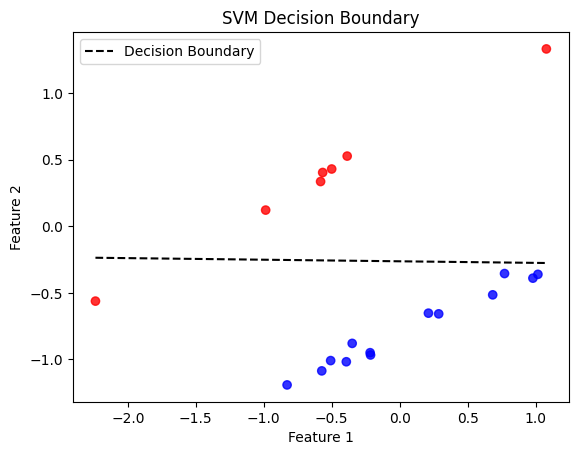

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# 1. Prepare your data
# Generate a synthetic dataset for binary classification
X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, random_state=42)

# Convert labels to -1 and 1, as hinge loss expects these values
y = torch.tensor(y * 2 - 1, dtype=torch.float32)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for SVMs)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# 2. Define the SVM model
class LinearSVM(nn.Module):
    def __init__(self, input_dim):
        super(LinearSVM, self).__init__()
        self.linear = nn.Linear(input_dim, 1) # A single linear layer for binary classification

    def forward(self, x):
        return self.linear(x)

# 3. Instantiate the model
input_dim = X_train.shape[1]
model = LinearSVM(input_dim)

# 4. Define the loss function and optimizer
# Hinge loss for SVM
criterion = nn.HingeEmbeddingLoss() # You can also implement your own hinge loss
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001) # SGD optimizer with L2 regularization (weight_decay)

# 5. Train the model
epochs = 100
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 6. Evaluate the model
model.eval() # Set the model to evaluation mode
with torch.no_grad(): # Disable gradient calculation during evaluation
    outputs = model(X_test).squeeze()
    predicted = (outputs > 0).float() * 2 - 1 # Convert scores to -1 or 1

    accuracy = accuracy_score(y_test, predicted)
    print(f'Accuracy on the test set: {accuracy:.4f}')

# (Optional) Visualize the decision boundary (for 2D data)
import matplotlib.pyplot as plt

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='bwr', alpha=0.8)

# Plot the decision boundary
w = model.linear.weight.data.numpy()
b = model.linear.bias.data.numpy()
x_line = np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 100)
y_line = (-w[0, 0] * x_line - b[0]) / w[0, 1]
plt.plot(x_line, y_line, color='black', linestyle='--', label='Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundary')
plt.legend()
plt.show()

Other sample questions for practice:

*   How does the learning rate impact model training?
*   Does data augmentation help with model skill?
*   Does reducing regularization impact overfitting (hint: reduce dropout percentage)?

In [ ]:
# more cells for practicing

# What happens if your model is not performing well? This may be related to issues in bias and/or variance...

---

### Bias / Variance Trade-off

*Subsection on bias/variance trade-off sourced from the AMS 2022 AI Short Course and the following [paper](http://scott.fortmann-roe.com/docs/BiasVariance.html)*

An important concept in machine learning is that of the "bias/variance trade-off." Prediction errors from any model can be decomposed into several terms: 1) error due to bias, 2) error due to variance, and 3) irreducible errors or noise. This concept refers to the trade-off that occurs in a models ability to reduce error in the bias and variance terms.

<img src="https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/images/bias_variance/bullseye.png" height= "600">

(image credit: [paper](http://scott.fortmann-roe.com/docs/BiasVariance.html))


### Bias

Bias is due to your model being consistently getting a certain type of error in relation to a particular kind of solution. For example, maximum temperatures in relation to the diurnal cycle might be predicted by your model consistently higher than what was observed. This error may be irreducible with more training data and be related to your model (i.e., inherent to your model). The error due to bias is taken as the difference between the expected (or average) prediction of our model and the correct value which we are trying to predict. Bias measures how far off in general these models' predictions are from the correct value.

### Variance

Variance relates to changes in your model's predictions based on new iterations of your model and thus captures how much your predictions change if your model is trained on a different training set (e.g., different data ordering). We can also think of this as how "over-specialized" your machine learning model may be to a particular training set (overfitting). The error due to variance is taken as the variability of a model's prediction for a given data point. Again, variance is how much the predictions for a given point vary between different realizations of the model.

### Irreducible Error/Noise

How big is the data-intrinsic noise? This error relates to ambiguity due to your data distribution and feature representation. You can never beat this, it is an aspect of the data.

# So, what do we do with this information?

If the training error is below your desired error threshold, but the test error is significantly higher, then the cause of the model's poor performance is high variance. In other words, we have overfit to the training set. We can remedy this issue by adding more training data and/or reducing the model's complexity. For decision trees, we can also perform "bagging."

If the training error and the test error are both above your desired error threshold, then the model being used is not robust or complex enough to produce accurate predictions. In other words, we have underfit to the training set. We can remedy this issue by using more complex model and/or adding more variables (features). For decision trees, we can also perform "boosting."

For more information, see [Cornell Lecture](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote12.html).

## Classification

---

**In classification problems**, we aim to predict the class of *something*. Classes are discrete in nature. We can frame our problem to be binary classification (two classes; e.g., True or False, or Yes or No problems). Classification problems can also be multiclass in nature.

Continuous data could be grouped or binned into certain classes, and thus, continuous data can be converted to classes (e.g., binning of continuous maximum tropical cyclone wind speeds into hurricane intensities based on the Saffir-Simpson Hurricane Wind Scale, e.g., category 1, category 2, etc.).

Ways to convert continuous data into classes include **integer encoding or one-hot encoding**. Integer encoding involves assigning an integer value to each unique category, and this can work well for data that have an underlying natural ordered relationship between each other, since machine learning models may be able to understand and harness this relationship. For one-hot encoding, a binary variable (i.e., zero or one) is added at a certain position in each sample's vector, which is meant to represent the respective sample's class, e.g., `[0, 0, 1]` vs `[1, 0, 0]`.

![supervised](https://drive.google.com/uc?export=view&id=1jDl42c0CSN9dvp37TMWJ1qI6fOQMGp4e)


Some examples of classification problems in the environmental sciences could include:

*   whether a thunderstorm will produce severe hazards or be non-severe (i.e., binary) (e.g., Molina et al. 2021)
*   whether a polynya event is occurring in the Ross Sea, Antarctica (i.e., binary) (e.g., DuVivier et al. 2023)
*   type of cloud(s) that is(are) in a citizen science photograph (i.e., multiclass)
*   subseasonal prediction of a North American weather regime class (i.e., multiclass) (e.g., Molina et al. 2023)

Similar to how explained in the regression section, when using various input variables (i.e., features or channels), normalizing or standardizing the variables is needed to make sure they have a similar dynamic range.

# Supervised Learning Classification Example

---

Using our work from the previous section, we will now use the data and reframe our problem to be a classification task. As before, we will use two input features.

However, we will use updraft helicity values (which represent storm updraft rotation) and convert this continuous value into two classes, "not potentially severe" and "potentially severe". More strongly rotating storms have a greater likelihood of producing severe hazards like tornadoes and large hail. We will use 75 m2/s2 as the delineation mark between the two classes. The two classes will be creating using integer encoding first, with 0 representing non-severe and 1 representing potentially severe, and then converting using one-hot encoding for subsequent training.

In [ ]:
features = xr.concat([
    ds['dbz_grid'].expand_dims(dim='feature', axis=3),
    ds['ctt_grid'].expand_dims(dim='feature', axis=3)],
          dim='feature')

labels = ds['uh25_grid'].expand_dims(dim='feature', axis=3).max('x').max('y')

train_feats, train_label, test_feats, test_label = random_split(features, labels)

# normalization of our training data (note each feature individually processed!)
train_feats_standardized = xr.concat([
    z_score(train_feats.isel(feature=0).expand_dims(dim='feature', axis=3)),
    z_score(train_feats.isel(feature=1).expand_dims(dim='feature', axis=3))],
                                     dim='feature')

train_label_ints = xr.where(train_label >= 75, 1, 0)

In [ ]:
print(train_label.values[-2:])
print(train_label_ints.values[-2:])

[[162.55905  ]
 [  1.8748366]]
[[1]
 [0]]


In [ ]:
# convert labels into classes using one-hot encoding
onehot_layer = keras.layers.CategoryEncoding(num_tokens=2, output_mode="one_hot")
train_y = onehot_layer(train_label_ints.astype(int))

In [ ]:
train_y[-2:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 1.],
       [1., 0.]], dtype=float32)>

In [ ]:
# out of more than 1000 samples, only 189 are the "severe" class
print(train_y[:,1].numpy().sum())
print(train_y[:,1].numpy().shape)

189.0
(1556,)


Class imbalance is a major issue with a minority class that is a rare event, like severe hazards. To address this limitation, we create class weights that help the machine learning model learn that the minority class is important to get correct.

In [ ]:
# generate class weights due to class imbalance issues
# use the second class as the positive one (using 1 index)
counts = np.bincount(train_y[:,1].numpy().astype(int))

print("Number of positive samples in training data: {} ({:.2f}% of total)".format(
    counts[1], 100 * float(counts[1]) / len(train_y)))

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

Number of positive samples in training data: 189 (12.15% of total)
{0: 0.000731528895391368, 1: 0.005291005291005291}


In [ ]:
# metrics that are useful for classification, particularly for two classes
METRICS = [
    keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
model = keras.Sequential()

# input
model.add(keras.Input(shape=(32, 32, number_of_features)))  # 32x32 images

# data augmentation layers
#model.add(layers.RandomFlip("horizontal_and_vertical"))
#model.add(layers.RandomRotation(factor=(-0.5,0.5)))

# hidden layers
model.add(layers.Conv2D(32, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))

# Now that we have 4x4 feature maps, now apply global max pooling.
model.add(layers.GlobalMaxPooling2D())

# Finally, we add last fully connected (dense) layers
model.add(layers.Dense(64))
model.add(layers.Dense(2, activation="softmax"))

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        608       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 64)         

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(), # categorical loss function
    metrics=METRICS
)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
print("Fit model on training data")
history = model.fit(
    x=train_feats_standardized.values,
    y=train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
    class_weight=class_weight,
)

Fit model on training data
Epoch 1/10
44/44 [==============================] - 5s 68ms/step - loss: 7.5593e-04 - cross entropy: 0.6303 - tp: 803.0000 - fp: 597.0000 - tn: 803.0000 - fn: 597.0000 - accuracy: 0.5736 - precision: 0.5736 - recall: 0.5736 - auc: 0.6796 - prc: 0.7109 - val_loss: 0.7091 - val_cross entropy: 0.7091 - val_tp: 69.0000 - val_fp: 87.0000 - val_tn: 69.0000 - val_fn: 87.0000 - val_accuracy: 0.4423 - val_precision: 0.4423 - val_recall: 0.4423 - val_auc: 0.6096 - val_prc: 0.6809
Epoch 2/10
44/44 [==============================] - 2s 48ms/step - loss: 6.0370e-04 - cross entropy: 0.5456 - tp: 876.0000 - fp: 524.0000 - tn: 876.0000 - fn: 524.0000 - accuracy: 0.6257 - precision: 0.6257 - recall: 0.6257 - auc: 0.7663 - prc: 0.7940 - val_loss: 0.6526 - val_cross entropy: 0.6526 - val_tp: 86.0000 - val_fp: 70.0000 - val_tn: 86.0000 - val_fn: 70.0000 - val_accuracy: 0.5513 - val_precision: 0.5513 - val_recall: 0.5513 - val_auc: 0.6744 - val_prc: 0.7179
Epoch 3/10
44/44 [=====

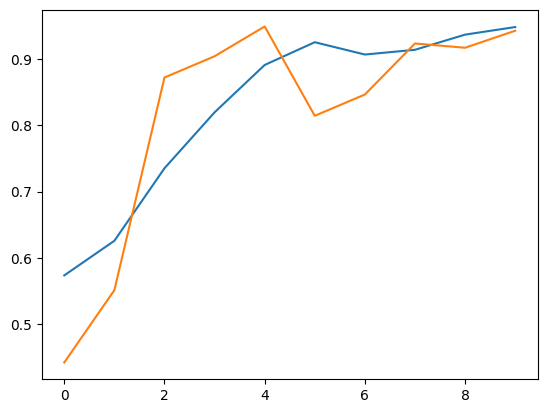

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
# normalization of our training data (note each feature individually processed!)
test_feats_standardized = xr.concat([
    z_score_testing(
        train_feats.isel(feature=0).expand_dims(dim='feature', axis=3),
        test_feats.isel(feature=0).expand_dims(dim='feature', axis=3)
        ),
    z_score_testing(
        train_feats.isel(feature=1).expand_dims(dim='feature', axis=3),
        test_feats.isel(feature=1).expand_dims(dim='feature', axis=3)
        )],
                                     dim='feature')

test_label_ints = xr.where(test_label >= 75, 1, 0)
test_y = onehot_layer(test_label_ints.astype(int))

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_feats_standardized.values, test_y, batch_size=128)
print(results)

Evaluate on test data
6/6 [==============================] - 0s 40ms/step - loss: 0.1566 - cross entropy: 0.1566 - tp: 634.0000 - fp: 34.0000 - tn: 634.0000 - fn: 34.0000 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9865 - prc: 0.9847
[0.15658392012119293, 0.15658392012119293, 634.0, 34.0, 634.0, 34.0, 0.9491018056869507, 0.9491018056869507, 0.9491018056869507, 0.9865292310714722, 0.9847036004066467]


In [ ]:
# generate predictions using the trained model
predictions = model.predict(test_feats_standardized.values)

21/21 [==============================] - 0s 14ms/step


In [ ]:
pred_ints = xr.where(predictions[:,1]>0.5, 1, 0)

In [ ]:
from sklearn.metrics.cluster import contingency_matrix
contingency_matrix(test_label_ints.astype(int).values.squeeze(), pred_ints)
# tend to predict more false positives

array([[555,  21],
       [ 13,  79]])

In [ ]:
test_label_ints.astype(int).sum().values

array(92)

In [ ]:
pred_ints.sum() - 92

8

# Tutorial Practice: What happens if we do not use class weights during training?

---

In [ ]:
# recreate the model object

In [ ]:
# recompile the model

In [ ]:
# retrain the model without class weights

In [ ]:
# evaluate the new model's skill

## **Unsupervised Learning**

---

Unsupervised learning refers to machine learning tasks where the dataset does not contain predictands (y) and solely contains predictors (x). In other words, in unsupervised learning, we do not know the "answers" or have labels beforehand. Unsupervised learning is particularly useful for dimensionality reduction, anomaly detection, image denoising, and pattern grouping (e.g., clustering).

![supervised](https://drive.google.com/uc?export=view&id=1HEcZ4VXU_Q9Y9rrgnRkAg4JdjRJSs9Nj)

Some examples of unsupervised learning problems in the environmental sciences include:

*   uncovering common polynya event patterns from sea ice concentration in the Ross Sea, Antarctica (e.g., DuVivier et al. 2023)
*   grouping high shear-low CAPE severe thunderstorm event environments (e.g., Campbell et al. 2024)
*   identifying subseasonal weather regimes over North America (e.g., Molina et al. 2023)
*   creating an index for a climate teleconnection, such as ENSO teleconnection to Southern California precipitation (e.g., Passarella and Mahajan 2023)



# Unsupervised Learning Example

---

We will be training an autoencoder to perform the task of anomaly detection. For anomaly detection, we would note instances where reconstruction error for an image is higher, indicating that the sample was likely not similar to those in the training set distribution.

We will again use the previous data, but this time we will focus on reconstructing one input variable (feature).

In [ ]:
features = xr.concat([
    ds['ctt_grid'].expand_dims(dim='feature', axis=3)],
          dim='feature')

# note that we are reconstructing the respective input image/variable
train_feats, _, test_feats, _ = random_split(features, features)

# normalization of our training data (note each feature individually processed!)
train_feats_standardized = xr.concat([
    z_score(train_feats.isel(feature=0).expand_dims(dim='feature', axis=3))],
                                     dim='feature')

In [ ]:
number_of_features = 1

In [ ]:
model = keras.Sequential()

# input
model.add(keras.Input(shape=(32, 32, number_of_features)))  # 32x32 images

# encoder
# hidden layers
model.add(layers.Conv2D(16, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(8, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(4, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

# decoder
model.add(layers.Conv2D(4, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

model.add(layers.Conv2D(8, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

model.add(layers.Conv2D(16, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

# Finally, we add last layer
model.add(layers.Conv2D(1, (3, 3), activation='linear', padding='same'))

# print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 8)         1160      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 8, 8, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 4)           292       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 4, 4, 4)          

In [ ]:
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
history = model.fit(
    x=train_feats_standardized.values,
    y=train_feats_standardized.values,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
44/44 [==============================] - 3s 40ms/step - loss: 0.6365 - mean_squared_error: 0.6365 - root_mean_squared_error: 0.7978 - val_loss: 0.4575 - val_mean_squared_error: 0.4575 - val_root_mean_squared_error: 0.6764
Epoch 2/10
44/44 [==============================] - 1s 27ms/step - loss: 0.1989 - mean_squared_error: 0.1989 - root_mean_squared_error: 0.4460 - val_loss: 0.0809 - val_mean_squared_error: 0.0809 - val_root_mean_squared_error: 0.2845
Epoch 3/10
44/44 [==============================] - 1s 27ms/step - loss: 0.0675 - mean_squared_error: 0.0675 - root_mean_squared_error: 0.2599 - val_loss: 0.0644 - val_mean_squared_error: 0.0644 - val_root_mean_squared_error: 0.2538
Epoch 4/10
44/44 [==============================] - 1s 26ms/step - loss: 0.0543 - mean_squared_error: 0.0543 - root_mean_squared_error: 0.2330 - val_loss: 0.0549 - val_mean_squared_error: 0.0549 - val_root_mean_squared_error: 0.2342
Epoch 5/10
44/44 [==============================] - 1s 27ms/step - l

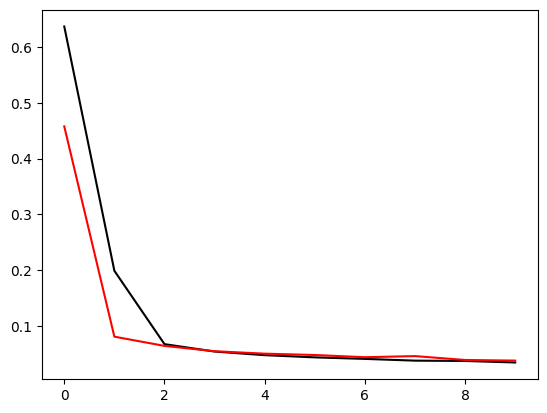

In [ ]:
plt.plot(history.history["mean_squared_error"], c='k')
plt.plot(history.history["val_mean_squared_error"], c='r')
plt.show()

In [ ]:
# normalization of our training data (note each feature individually processed!)
test_feats_standardized = xr.concat([
    z_score_testing(
        train_feats.isel(feature=0).expand_dims(dim='feature', axis=3),
        test_feats.isel(feature=0).expand_dims(dim='feature', axis=3)
        )],
                                     dim='feature')

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_feats_standardized.values, test_feats_standardized.values, batch_size=128)
print(results)

Evaluate on test data
6/6 [==============================] - 0s 24ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - root_mean_squared_error: 0.1865
[0.034794196486473083, 0.034794196486473083, 0.18653202056884766]


21/21 [==============================] - 0s 9ms/step
The prediction loss threshold for 2% of outliers is 0.27


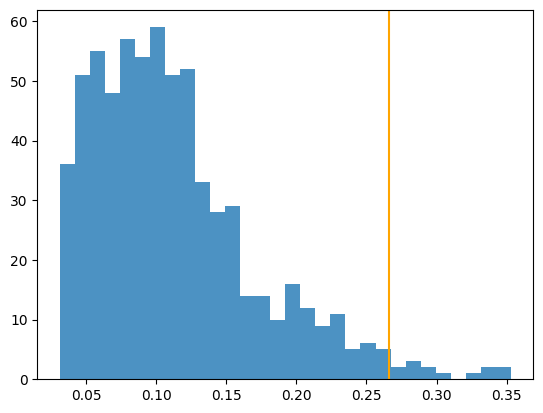

In [ ]:
# for predict anomalies/outliers in the training dataset
prediction = model.predict(test_feats_standardized.values)

# for get the mean absolute error between actual and reconstruction/prediction
prediction_loss = keras.losses.mae(prediction, test_feats_standardized.values)

# for check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(np.mean(prediction_loss, axis=(1,2)), 98)

print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')
# for visualize the threshold
plt.hist(np.mean(prediction_loss, axis=(1,2)), bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')
plt.show()

# References

Campbell, T., G. M. Lackmann, M. J. Molina, and M. D. Parker (2024). Severe Convective Storms in Limited Instability Organized by Pattern and Distribution. Weather and Forecasting. https://journals.ametsoc.org/view/journals/wefo/39/1/WAF-D-23-0130.1.xml

DuVivier, A. K., M. J. Molina, A. L. Deppenmeier, M. M. Holland, L. Landrum, K. Krumhardt, and S. Jenouvrier (2023). Projections of Winter Polynyas and Their Biophysical Impacts in the Ross Sea Antarctica. Climate Dynamics. https://link.springer.com/article/10.1007/s00382-023-06951-z

Molina, M. J., D. J. Gagne, and A. F. Prein (2021). A benchmark to test generalization capabilities of deep learning methods to classify severe convective storms in a changing climate. Earth and Space Science. https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020EA001490

Molina, M. J., T. A. O'Brien, G. Anderson, M. Ashfaq, K. E. Bennett, W. D. Collins, K. Dagon, J. M. Restrepo, and P. A. Ullrich (2023). A Review of Recent and Emerging Machine Learning Applications for Climate Variability and Weather Phenomena. Artificial Intelligence for the Earth Systems. https://journals.ametsoc.org/view/journals/aies/2/4/AIES-D-22-0086.1.xml

Molina, M. J., J. H. Richter, A. A. Glanville, K. Dagon, J. Berner, A. Hu, and G. A. Meehl (2023). Subseasonal Representation and Predictability of North American Weather Regimes using Cluster Analysis. Artificial Intelligence for the Earth Systems. https://journals.ametsoc.org/view/journals/aies/2/2/AIES-D-22-0051.1.xml

Passarella, L.S. and Mahajan, S., 2023. Assessing Tropical Pacific–Induced Predictability of Southern California Precipitation Using a Novel Multi-Input Multioutput Autoencoder. Artificial Intelligence for the Earth Systems, 2(4), p.e230003. https://journals.ametsoc.org/view/journals/aies/2/4/AIES-D-23-0003.1.xml